In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge, Lasso

In [2]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()
X=california.data
DF=pd.DataFrame(X,columns=california.feature_names)
Y=california.target
print(DF)

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  
0        -122.23  
1

In [3]:
'''
코드 실행 전에 아나콘다 프롬프트에서 'machinelearning' 가상환경을 활성화시킨 후 'conda install statsmodels'로 
통계량 계산 라이브러리(패키지)를 설치해야한다.

''' 
import statsmodels.api as sm

#forward selection 함수 정의: 입력변수를 하나씩 추가하면서 최소 p-value가 기준값인 cutoff-value보다 큰 변수가 나올 때까지 반복한다.
#함수의 인자로 있는 cutoff 매개변수 값을 조절하면서 학습하면 된다.
def forward_selection(data,target,cutoff=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while(len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value < cutoff):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features
forwarddata=forward_selection(DF,Y,0.01)
print(forwarddata)

<ipython-input-3-cb60dfdb9cb7>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-3-cb60dfdb9cb7>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-3-cb60dfdb9cb7>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-3-cb60dfdb9cb7>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


['MedInc', 'HouseAge', 'Latitude', 'Longitude', 'AveBedrms', 'AveRooms', 'AveOccup']


In [4]:
#backward elimination 함수 정의: full model에서 입력변수를 하나씩 제거하면서 남아 있는 모든 입력변수 중 쵀대 p-value가 cutoff-value보다 낮아질 때까지 반복한다. 
#함수의 인자로 있는 cutoff 매개변수 값을 조절하면서 학습하면 된다.
def backward_elimination(data, target, cutoff= 0.05):
    features = data.columns.tolist()
    while(len(features) > 0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= cutoff):
            excluded_feature=p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

backwarddata=backward_elimination(DF,Y,0.01)
print(backwarddata)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude']


In [5]:
#stepwise selection 함수 정의: 위의 두 함수의 원리를 결합한 형태로 반복한다.
#함수의 인자로 있는 cutoff 매개변수 값을 조절하면서 학습하면 된다.
def stepwise_selection(data,target,cutoff):
    initial_features = data.columns.tolist()
    best_features = []
    while(len(initial_features) > 0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value < cutoff):
            best_features.append(new_pval.idxmin())
            while(len(best_features) > 0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= cutoff):
                    excluded_feature=p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break
        else:
            break
    return best_features

stepdata=stepwise_selection(DF,Y,0.01)
print(stepdata)

<ipython-input-5-fba75914e991>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-5-fba75914e991>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-5-fba75914e991>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-5-fba75914e991>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipy

['MedInc', 'HouseAge', 'Latitude', 'Longitude', 'AveBedrms', 'AveRooms', 'AveOccup']


<ipython-input-5-fba75914e991>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-5-fba75914e991>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


No handles with labels found to put in legend.


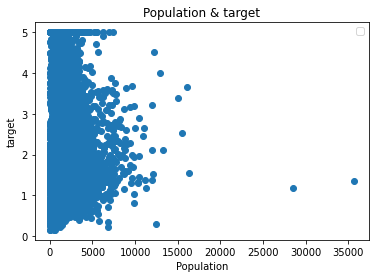

In [6]:
#i번째 feature와 타겟 값 사이의 관계 시각화
i=4
plt.title(california.feature_names[i]+' & ' + 'target')
plt.xlabel(california.feature_names[i])
plt.ylabel('target')
plt.scatter(DF[california.feature_names[i]],Y)
plt.legend()
plt.show()